In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed
from tensorflow.keras.models import Sequential
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

import keras
from keras.layers import *
from keras.models import Model

from keras.applications.vgg16 import preprocess_input, VGG16
from keras.regularizers import l2

from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm

from keras.layers import Input, concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

In [ ]:
!pip install keras-applications

   ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
   ---------------- ----------------------- 20.5/50.7 kB ? eta -:--:--
   -------------------------------- ------- 41.0/50.7 kB 991.0 kB/s eta 0:00:01
   -------------------------------- ------- 41.0/50.7 kB 991.0 kB/s eta 0:00:01
   -------------------------------- ------- 41.0/50.7 kB 991.0 kB/s eta 0:00:01
   -------------------------------- ------- 41.0/50.7 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 50.7/50.7 kB 185.6 kB/s eta 0:00:00


In [ ]:
import tensorflow as tf

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate 3GB of GPU memory
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3200)]
        )
    except RuntimeError as e:
        print(e)

In [ ]:
folder_path = 'OneDrive\\Desktop\\age and gender practiction\\utkcropped'

In [ ]:
age =[]
gender =[]
image_path =[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  image_path.append(file)

In [ ]:
len(age)

23709

In [ ]:
df = pd.DataFrame({'age':age,'gender':gender,'image':image_path})

In [ ]:
# male - 0 female -1

In [ ]:
df.head()

age  gender                                   image
0  100       0  100_0_0_20170112213500903.jpg.chip.jpg
1  100       0  100_0_0_20170112215240346.jpg.chip.jpg
2  100       1  100_1_0_20170110183726390.jpg.chip.jpg
3  100       1  100_1_0_20170112213001988.jpg.chip.jpg
4  100       1  100_1_0_20170112213303693.jpg.chip.jpg

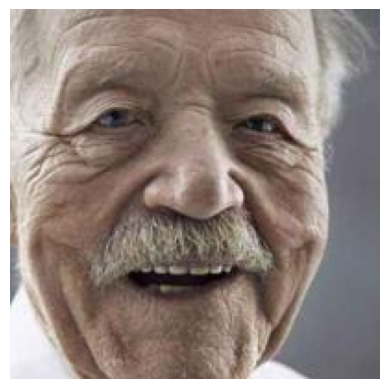

In [ ]:
# Select an image from the DataFrame
selected_image_index = 0  # You can change this index to view other images
selected_image_path = os.path.join(folder_path, df['image'][selected_image_index])

# Read the image with OpenCV
image = cv2.imread(selected_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the RGB image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [ ]:
df.shape

(23709, 3)

In [ ]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_df.shape

(20000, 3)

In [ ]:
test_df.shape

(3709, 3)

In [ ]:
#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='image',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='image',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    batch_size = 32,
                                                    class_mode='multi_output')

Found 20000 validated image filenames.
Found 3709 validated image filenames.


In [ ]:
vgg = VGG16(
    include_top = False,
    input_shape=(200,200,3)
)

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
vgg.trainable = False

output = vgg.layers[-1].output

flatten = Flatten()(output)

dense_1 = Dense(512,activation='relu')(flatten)
dense_2 = Dense(512,activation= 'relu')(flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

dense_3 = Dense(128, activation= 'relu')(dropout_1)
dense_4 = Dense(128, activation='relu')(dropout_2)

dropout_3 = Dropout(0.3) (dense_3)
dropout_4 = Dropout(0.3) (dense_4)

dense_5 = Dense(32, activation='relu')(dropout_3)
dense_6 = Dense(32, activation='relu')(dropout_4)

dropout_5 = Dropout(0.3) (dense_5)
dropout_6 = Dropout(0.3) (dense_6)

output_1 = Dense(1, activation ='relu', name = 'age')(dropout_5)
output_2 = Dense(1, activation ='sigmoid', name = 'gender')(dropout_6)


In [ ]:
model = Model(inputs = vgg.input, outputs=[output_1, output_2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
model.compile(optimizer='adam', loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'})


In [ ]:
model.fit(train_generator, batch_size=32, epochs=100,validation_data= test_generator)

Epoch 1/100
625/625 [==============================] - 148s 218ms/step - loss: 14.3095 - age_loss: 13.6561 - gender_loss: 0.6535 - age_mae: 13.6561 - gender_accuracy: 0.6274 - val_loss: 10.0555 - val_age_loss: 9.6172 - val_gender_loss: 0.4384 - val_age_mae: 9.6172 - val_gender_accuracy: 0.8032
Epoch 2/100
625/625 [==============================] - 128s 205ms/step - loss: 12.2840 - age_loss: 11.7713 - gender_loss: 0.5127 - age_mae: 11.7713 - gender_accuracy: 0.7422 - val_loss: 11.1539 - val_age_loss: 10.7700 - val_gender_loss: 0.3839 - val_age_mae: 10.7700 - val_gender_accuracy: 0.8258
Epoch 3/100
625/625 [==============================] - 131s 210ms/step - loss: 11.8617 - age_loss: 11.3782 - gender_loss: 0.4835 - age_mae: 11.3782 - gender_accuracy: 0.7520 - val_loss: 11.0363 - val_age_loss: 10.6689 - val_gender_loss: 0.3674 - val_age_mae: 10.6689 - val_gender_accuracy: 0.8425
Epoch 4/100
625/625 [==============================] - 126s 202ms/step - loss: 11.4852 - age_loss: 11.0179 - ge

In [ ]:
model.compile(optimizer='adam', loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'})

In [ ]:
model.fit(train_generator, batch_size=32, epochs=50,validation_data= test_generator)

Epoch 1/50
625/625 [==============================] - 115s 184ms/step - loss: 8.9394 - age_loss: 8.5510 - gender_loss: 0.3883 - age_mae: 8.5510 - gender_accuracy: 0.8077 - val_loss: 7.9378 - val_age_loss: 7.6339 - val_gender_loss: 0.3039 - val_age_mae: 7.6339 - val_gender_accuracy: 0.8706
Epoch 2/50
625/625 [==============================] - 118s 188ms/step - loss: 8.8836 - age_loss: 8.4989 - gender_loss: 0.3848 - age_mae: 8.4989 - gender_accuracy: 0.8092 - val_loss: 8.5356 - val_age_loss: 8.2415 - val_gender_loss: 0.2941 - val_age_mae: 8.2415 - val_gender_accuracy: 0.8722
Epoch 3/50
625/625 [==============================] - 116s 185ms/step - loss: 8.9235 - age_loss: 8.5353 - gender_loss: 0.3882 - age_mae: 8.5353 - gender_accuracy: 0.8071 - val_loss: 8.3278 - val_age_loss: 8.0417 - val_gender_loss: 0.2861 - val_age_mae: 8.0417 - val_gender_accuracy: 0.8717
Epoch 4/50
625/625 [==============================] - 117s 186ms/step - loss: 8.8861 - age_loss: 8.4931 - gender_loss: 0.3930 - ag

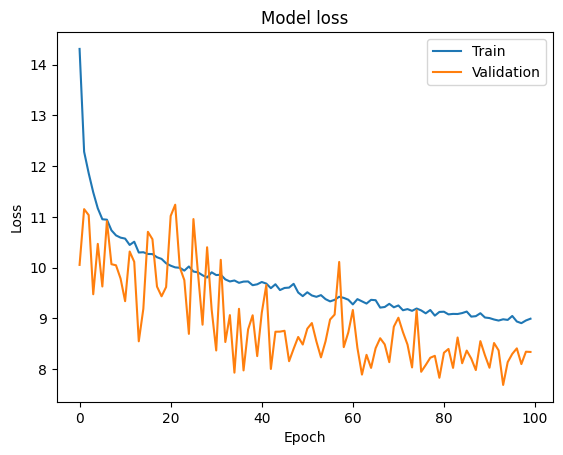

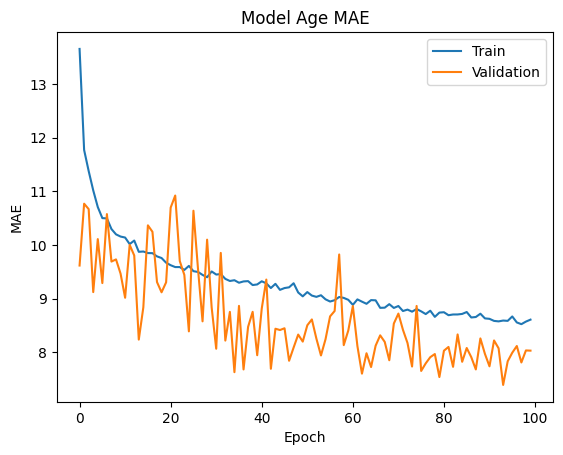

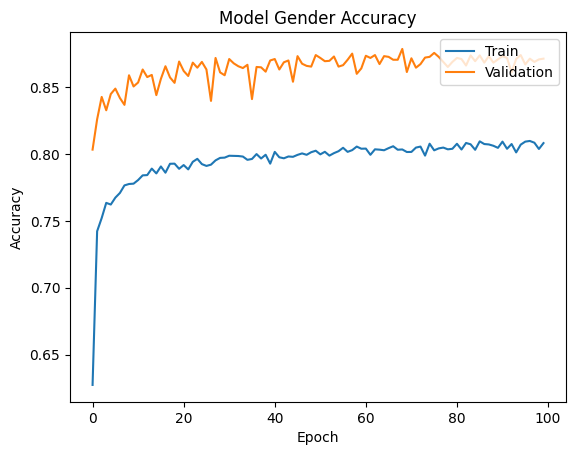

In [ ]:
# prompt: plot the all parameters of the epoch

import matplotlib.pyplot as plt

# Get the history object from the model's training
history = model.history

# Plot the loss and accuracy curves for both the training and validation sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('Model Age MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('Model Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
# model_path = 'OneDrive\\Desktop\\age and gender practiction\\age_gen_net_part2,.h5'
# model.save(model_path)

In [ ]:
model_path = 'OneDrive\\Desktop\\age and gender practiction\\age_gen_net_vgg2.h5'
model.save(model_path)

In [ ]:
model_path = 'OneDrive\\Desktop\\age and gender practiction\\age_gen_net_vgg.h5'

In [ ]:
model = tf.keras.models.load_model(model_path)

In [ ]:
img_path = 'Downloads\\ani.jpg'

In [ ]:
# def show_image(img_path):
#   img = cv2.imread(img_path)
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   plt.imshow(img)
#   plt.show()
#   img = cv2.resize(img,(200,200))
#   img = img/255.0
#   img = np.expand_dims(img,axis=0)
#   pred = model.predict(img)
#   print('Predicted Gender:',pred[1][0])
#   print('Predicted Age:',pred[0][0])


In [ ]:
from numpy import round

In [ ]:
def show_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  img = cv2.resize(img,(200,200))
  img = img/255.0
  img = np.expand_dims(img,axis=0)
  pred = model.predict(img)
  print(pred[1][0])
  if pred[1][0] > 0.3:
    print('Predicted Gender:', 'female')
  else:
    print('Predicted Gender:', 'male')
  print('Predicted Age:', round(pred[0][0], 2))



In [ ]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(200,200))
img = img/255.0
print(img)

In [ ]:
type(img)

numpy.ndarray

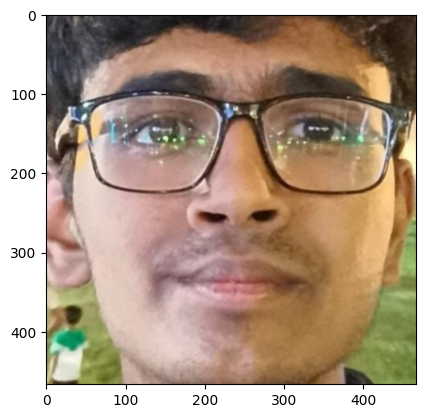

1/1 [==============================] - 0s 25ms/step
[0.24917643]
Predicted Gender: male
Predicted Age: [23.22]


In [ ]:
show_image(img_path)

In [ ]:
img_path = 'Downloads\\ronu.jpg'

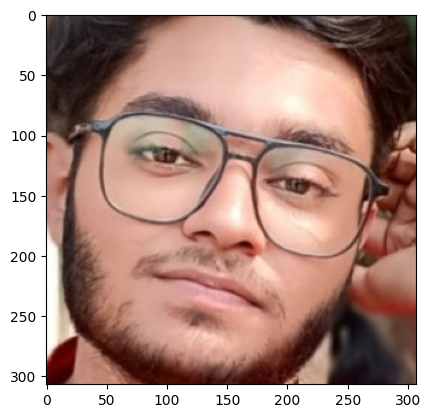

1/1 [==============================] - 0s 24ms/step
[0.11787355]
Predicted Gender: male
Predicted Age: [30.38]


In [ ]:
show_image(img_path)

In [ ]:
img_path = 'OneDrive\\Desktop\\age and gender practiction\\utkcropped\\14_1_4_20170109205457235.jpg.chip.jpg'

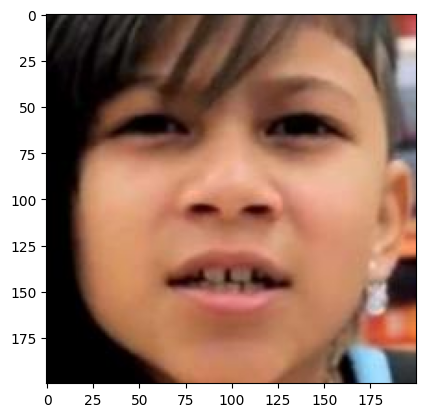

1/1 [==============================] - 0s 24ms/step
[0.46409294]
Predicted Gender: female
Predicted Age: [9.41]


In [ ]:
show_image(img_path)

In [ ]:
img_path = 'Downloads\\amitav.jpg'

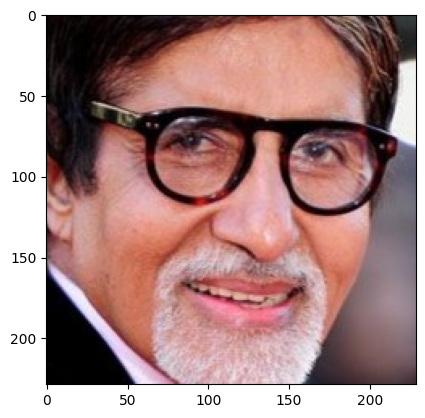

1/1 [==============================] - 0s 28ms/step
[0.46040308]
Predicted Gender: female
Predicted Age: [46.46]


In [ ]:
show_image(img_path)

In [ ]:
img_path = 'Downloads\\maa.jpg'

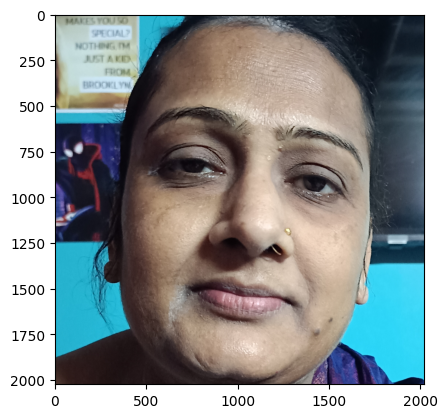

1/1 [==============================] - 0s 23ms/step
[0.3132919]
Predicted Gender: female
Predicted Age: [35.81]


In [ ]:
show_image(img_path)

400
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110224751365.jpg.chip.jpg


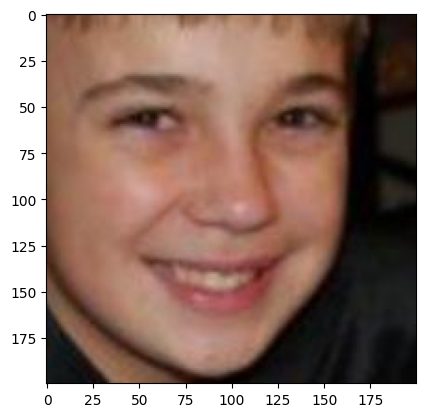

1/1 [==============================] - 0s 165ms/step
[0.8497833]
Predicted Gender: female
Predicted Age: [33.14]
401
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110224801290.jpg.chip.jpg


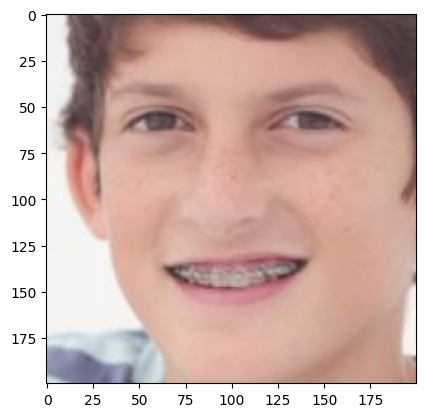

1/1 [==============================] - 0s 25ms/step
[0.3013957]
Predicted Gender: female
Predicted Age: [14.83]
402
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225045970.jpg.chip.jpg


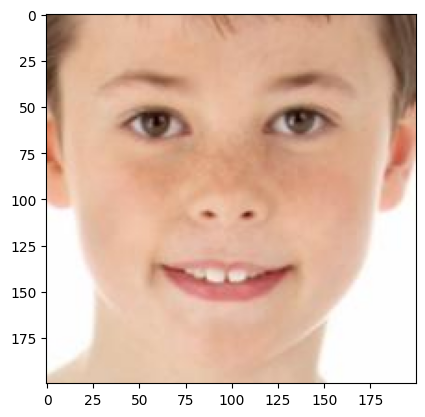

1/1 [==============================] - 0s 22ms/step
[0.6745595]
Predicted Gender: female
Predicted Age: [15.21]
403
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225059227.jpg.chip.jpg


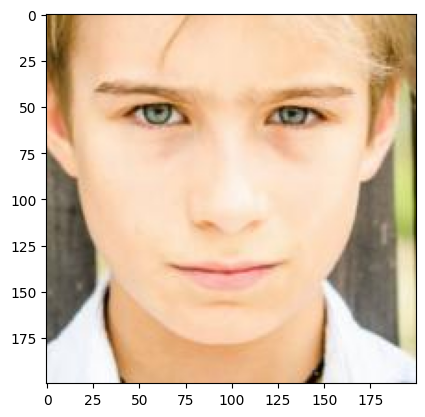

1/1 [==============================] - 0s 20ms/step
[0.03319687]
Predicted Gender: male
Predicted Age: [15.]
404
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225302179.jpg.chip.jpg


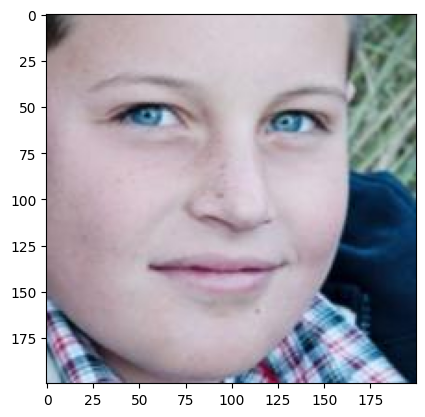

1/1 [==============================] - 0s 19ms/step
[0.8040897]
Predicted Gender: female
Predicted Age: [13.09]
405
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225307195.jpg.chip.jpg


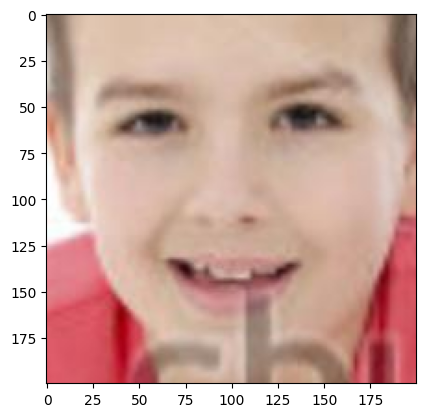

1/1 [==============================] - 0s 18ms/step
[0.7202502]
Predicted Gender: female
Predicted Age: [14.03]
406
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225428740.jpg.chip.jpg


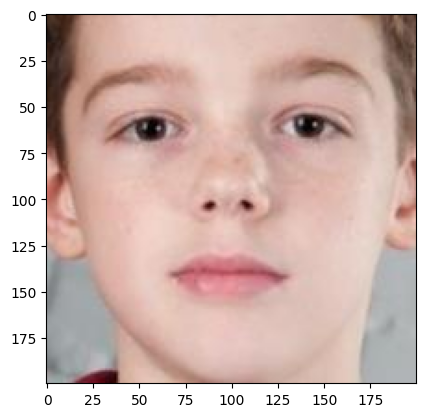

1/1 [==============================] - 0s 18ms/step
[0.48038414]
Predicted Gender: female
Predicted Age: [10.3]
407
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225438328.jpg.chip.jpg


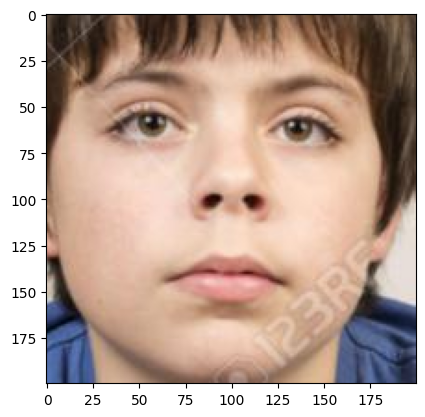

1/1 [==============================] - 0s 20ms/step
[0.48038414]
Predicted Gender: female
Predicted Age: [14.12]
408
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225447389.jpg.chip.jpg


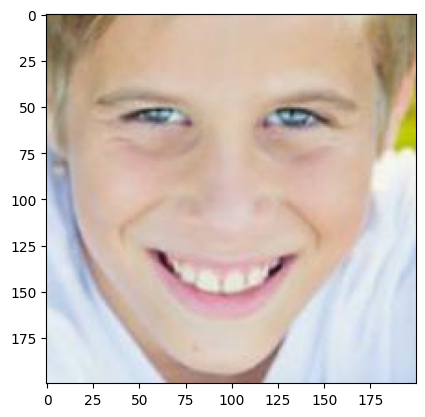

1/1 [==============================] - 0s 21ms/step
[0.6535963]
Predicted Gender: female
Predicted Age: [7.33]
409
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225513115.jpg.chip.jpg


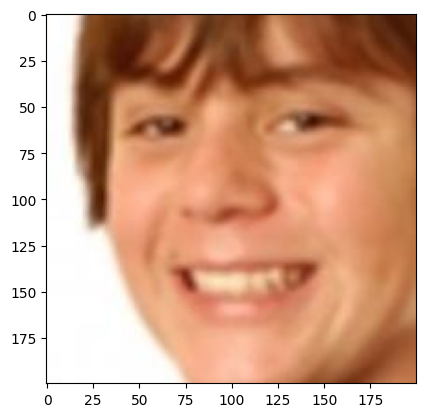

1/1 [==============================] - 0s 19ms/step
[0.40970635]
Predicted Gender: female
Predicted Age: [34.63]
410
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110225717809.jpg.chip.jpg


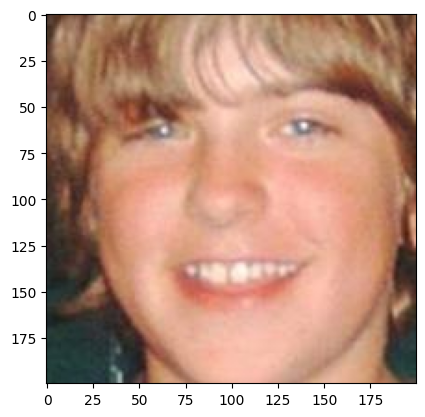

1/1 [==============================] - 0s 20ms/step
[0.48038414]
Predicted Gender: female
Predicted Age: [34.38]
411
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110232519225.jpg.chip.jpg


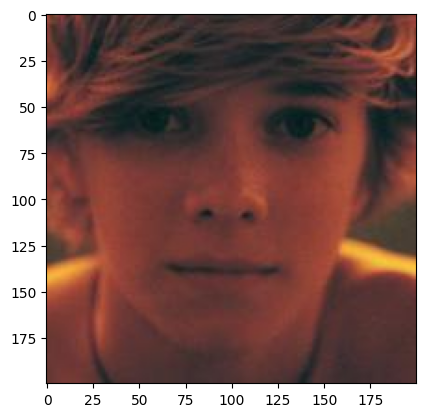

1/1 [==============================] - 0s 18ms/step
[0.20846769]
Predicted Gender: male
Predicted Age: [30.48]
412
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_0_20170110232526929.jpg.chip.jpg


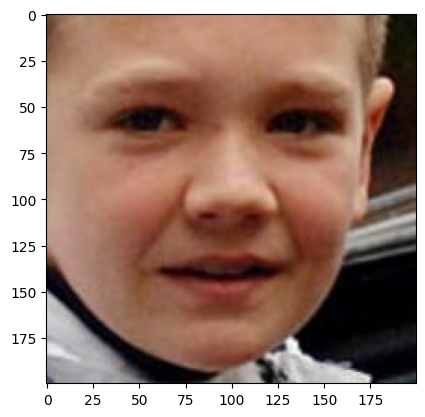

1/1 [==============================] - 0s 19ms/step
[0.24215122]
Predicted Gender: male
Predicted Age: [0.]
413
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_1_20170110232537879.jpg.chip.jpg


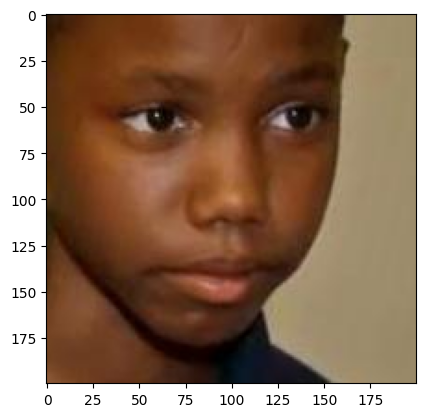

1/1 [==============================] - 0s 19ms/step
[0.48038414]
Predicted Gender: female
Predicted Age: [12.17]
414
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_1_20170113150907477.jpg.chip.jpg


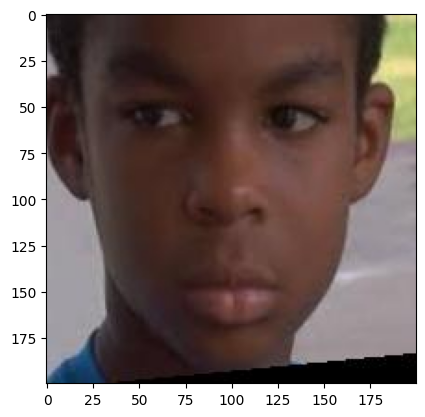

1/1 [==============================] - 0s 19ms/step
[0.01720012]
Predicted Gender: male
Predicted Age: [18.93]
415
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_2_20170103201143159.jpg.chip.jpg


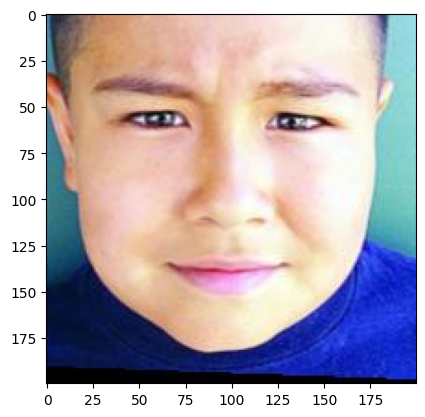

1/1 [==============================] - 0s 19ms/step
[0.0154127]
Predicted Gender: male
Predicted Age: [11.2]
416
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_2_20170103201417686.jpg.chip.jpg


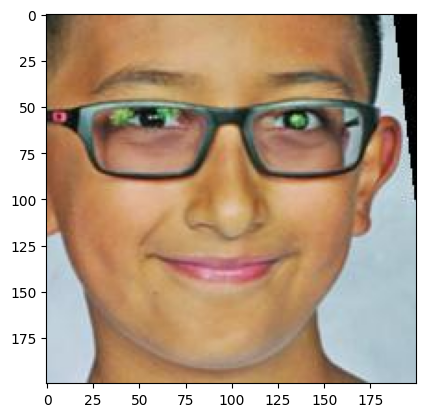

1/1 [==============================] - 0s 19ms/step
[0.48038414]
Predicted Gender: female
Predicted Age: [30.7]
417
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_2_20170117152653604.jpg.chip.jpg


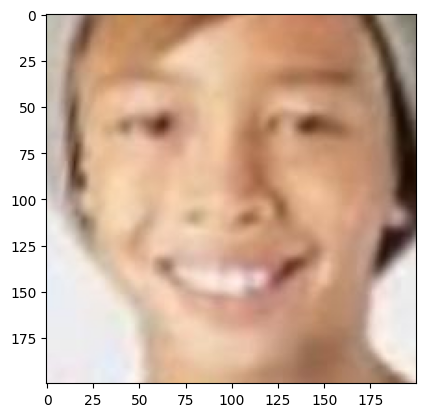

1/1 [==============================] - 0s 18ms/step
[0.3953098]
Predicted Gender: female
Predicted Age: [28.13]
418
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_3_20170110232628896.jpg.chip.jpg


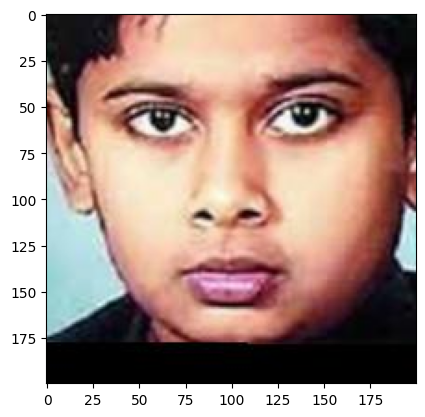

1/1 [==============================] - 0s 20ms/step
[0.42255]
Predicted Gender: female
Predicted Age: [18.]
419
OneDrive\Desktop\age and gender practiction\utkcropped\13_0_3_20170119153840721.jpg.chip.jpg


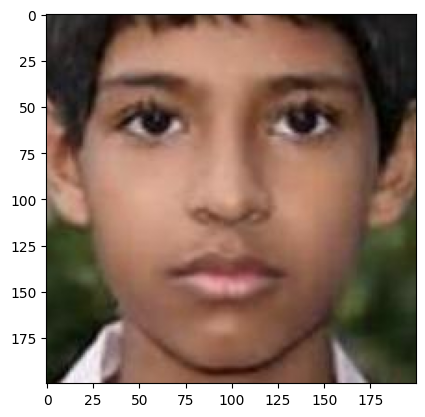

1/1 [==============================] - 0s 20ms/step
[0.09279281]
Predicted Gender: male
Predicted Age: [26.21]


In [ ]:
for i in range(400, 420):
  print(i)
  selected_image_index = i  # You can change this index to view other images
  selected_image_path = os.path.join(folder_path, df['image'][selected_image_index])
  print(selected_image_path)
  show_image(selected_image_path)

In [ ]:
selected_image_path


'OneDrive\\Desktop\\age and gender practiction\\utkcropped\\14_1_2_20170103200931103.jpg.chip.jpg'

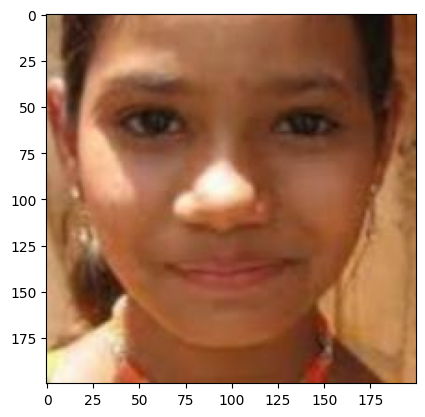

1/1 [==============================] - 0s 21ms/step
Predicted Gender: female
Predicted Age: [21.16]


In [ ]:
show_image(selected_image_path)

In [ ]:
import cv2
import numpy as np

# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces and resize them to (200, 200)
def detect_faces(camera):
    while True:
        # Capture frame-by-frame
        ret, frame = camera.read()

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Iterate over each detected face
        for (x, y, w, h) in faces:
            # Extract the face region
            face_roi = frame[y:y+h, x:x+w]

            # Resize the face region to (200, 200)
            face_resized = cv2.resize(face_roi, (200, 200))

            # Return the face image as a NumPy array
            return face_resized

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera
    camera.release()
    cv2.destroyAllWindows()

# Open the default camera
camera = cv2.VideoCapture(0)

# Call the function to detect faces
face_image = detect_faces(camera)
face_image = face_image/255.0
print(face_image.shape)  # Print the shape of the returned face image
print(face_image)
# Release the camera
camera.release()


In [ ]:
face_image = np.expand_dims(face_image,axis=0)
pred = model.predict(face_image)
if pred[1][0] > 0.5:
  print('Predicted Gender:', 'female')
else:
  print('Predicted Gender:', 'male')
print('Predicted Age:', round(pred[0][0], 2))

1/1 [==============================] - 0s 34ms/step
Predicted Gender: male
Predicted Age: [38.93]


In [ ]:
import cv2
import numpy as np

# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces and resize them to (200, 200)
def detect_faces(camera):
    while True:
        # Capture frame-by-frame
        ret, frame = camera.read()

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Iterate over each detected face
        for (x, y, w, h) in faces:
            # Draw a rectangle around the face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

            # Extract the face region
            face_roi = frame[y:y+h, x:x+w]

            # Resize the face region to (200, 200)
            face_resized = cv2.resize(face_roi, (200, 200))
            face_resized = face_resized/255.0
            # Print the face image values
            face_resized = np.expand_dims(face_resized,axis=0)
            pred = model.predict(face_resized)
            print(pred[1][0])
            if pred[1][0] > 0.3:
              print('Predicted Gender:', 'female')
            else:
              print('Predicted Gender:', 'male')
            print('Predicted Age:', round(pred[0][0], 2))

        # Display the frame
        cv2.imshow('Frame', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera
    camera.release()
    cv2.destroyAllWindows()

# Open the default camera
camera = cv2.VideoCapture(0)

# Call the function to detect faces
detect_faces(camera)
